In [1]:
from __future__ import absolute_import, print_function, unicode_literals
from gameclass import Game,check_init_game_done
from spritebuilder import SpriteBuilder
from players import Player
from sprite import MovingSprite
from ontology import Ontology
from itertools import chain
from astar import astar
import pygame
import glo
import random 
import numpy as np
import sys
import matplotlib.pyplot as plt
%matplotlib inline  

pygame 1.9.6
Hello from the pygame community. https://www.pygame.org/contribute.html


In [2]:
game = Game()

def init(_boardname=None):
    global player,game
    # pathfindingWorld_MultiPlayer4
    name = _boardname if _boardname is not None else 'kolkata_6_10'
    game = Game('Cartes/' + name + '.json', SpriteBuilder)
    game.O = Ontology(True, 'SpriteSheet-32x32/tiny_spritesheet_ontology.csv')
    game.populate_sprite_names(game.O)
    game.fps = 5  # frames per second
    game.mainiteration()
    game.mask.allow_overlaping_players = True
    #player = game.player

In [3]:
""" Retourne le restaurant le plus frequenté"""
def plus_frequent(frequentation ,  nb_restaus ):
    _max = 0
    res = 0
    for restau in range(nb_restaus):
        if _max < frequentation[restau]:
            res = restau
            _max = frequentation[restau]
    return res

In [4]:
""" Retourne le restaurant le plus frequenté"""
def moins_frequent(frequentation ,  nb_restaus ):
    _min = 100000
    res = 0
    for restau in range(nb_restaus):
        if _min > frequentation[restau]:
            res = restau
            _min = frequentation[restau]
    return res

### Choix du restaurant selon la strategie 
**Random :** choix aleatoire uniforme.

**Tetue :** choisit toujour le meme restaurant.

**Changeenperdant :** choisit aleatoirement quand un restaurant est vide (il y'a que lui) , il choisit le meme a l'iteration suivante.

**Changeenperdant :** choisit aleatoirement quand un restaurant n'est pas vide , il choisit le meme a l'iteration suivante.

**plusfrequent :** choisit le restaurant le plus frequenté aux iteration precedente

**moinsfrequent :** choisit le restaurant le moins frequenté aux iteration precedente

In [5]:
def choix_restau(nbRestaus , strategy, preced, etaitseul , frequentation):
    """
        nbRestauc : le nombre des restaurant 
        strategy : la strategie du joueur
        preced : le restaurant choisit par ce joueur a l'iteration precedente
        etaitseul : un booleen qui est a vrai quand le joeur est le seule dans son restaurant a l'iteration precedente
        it : nombre d'iteration total
    """
    if strategy == "random" or ( (strategy == "tetue"  )  and preced == -1) or (strategy == "changeenperdant" and etaitseul == False) or (strategy == "changeengagnant" and (etaitseul == True or preced == -1)):
        return random.randint(0,nbRestaus-1)
    if strategy == "tetue" or (strategy == "changeenperdant" and etaitseul == True) or (strategy == "changeengagnant" and etaitseul == False ) :
        return preced
    if strategy == "plusfrequent":
        return plus_frequent(frequentation , nbRestaus)
    if strategy == "moinsfrequent":
        return moins_frequent(frequentation , nbRestaus)    

In [6]:
"""Caclul du gain de chaque joueur"""
def calcul_gain(nbRestaus , frequentation ,gain ):
    etaitseul =[False]* len(gain)
    for i in range(nbRestaus):
        if len(frequentation[i]) == 1:
            gain[frequentation[i][0]] += 1
            etaitseul[frequentation[i][0]] = True
        if len(frequentation[i]) > 1: 
            gain[random.choice(frequentation[i])] += 1

    return etaitseul 

In [7]:
def kolkata(mode = ["random", "tetue"]):  #par defaut on compare les deux strategies du base
    
    #for arg in sys.argv:
    iterations = 20 # default

    init()

    #-------------------------------
    # Initialisation
    #-------------------------------
    nbLignes = game.spriteBuilder.rowsize
    nbColonnes = game.spriteBuilder.colsize
    #print("lignes", nbLignes)
    #print("colonnes", nbColonnes)
        
    
    players = [o for o in game.layers['joueur']]
    nbPlayers = len(players)

    #choix des strategies
    strategies = [""]*nbPlayers
    for j in range (nbPlayers):
        strategies[j] = mode [j % len(mode)]
    
    #print ("strategies -- " , strategies)

    # on localise tous les états initiaux (loc du joueur)
    initStates = [o.get_rowcol() for o in game.layers['joueur']]
    #print ("Init states:", initStates)
        
    
    # on localise tous les objets  ramassables (les restaurants)
    goalStates = [o.get_rowcol() for o in game.layers['ramassable']]
    #print ("Goal states:", goalStates)
    nbRestaus = len(goalStates)

    # on localise tous les murs
    wallStates = [w.get_rowcol() for w in game.layers['obstacle']]
    #print ("Wall states:", wallStates)

    # on liste toutes les positions permises
    allowedStates = [(x,y) for x in range(nbLignes) for y in range(nbColonnes)\
                     if (x,y) not in wallStates or  goalStates] 
    paths = [[]]*nbPlayers
    restau=[-1]*nbPlayers
    frequentation = {i:{j:[] for j in range(nbRestaus)} for i in range(iterations)} #frequentaion a chaque iteration
    taux_freq = {j:0 for j in range(nbRestaus)}  #taux de frequentation aux iteration precedente
    gain = [0]*nbPlayers
    etaitseul = [False]*nbPlayers
    stats = {strategy:{"score" : 0 , "max" : 0, "produit": 1} for strategy in mode} 
    graph_score = {strategy: [0]*iterations for strategy in mode} #utilise pour dessiner le graphe des scores
    for i in range(iterations):
        #print('gain -- ', gain)
        #print('iteration -- ', i)
        #-------------------------------
        # Placement aleatoire des joueurs, en évitant les obstacles
        #-------------------------------
        
        posPlayers = initStates

        for j in range(nbPlayers):
            x,y = random.choice(allowedStates)
            players[j].set_rowcol(x,y)
            game.mainiteration()
            posPlayers[j]=(x,y)
            restau[j] = choix_restau(nbRestaus,strategies[j] ,restau[j],etaitseul[j],taux_freq) #choix des restaurants
            frequentation[i][restau[j]].append(j)
        
        for res in taux_freq:
            taux_freq[res] = sum ([len (frequentation[k][res]) for k in range(iterations)])
        etaitseul = calcul_gain(nbRestaus,frequentation[i] , gain)
        for j in range(nbPlayers):
            graph_score[strategies[j]][i] += gain[j] 
        
        #Deplacement en Utilisant A*
        """for j in range(nbPlayers): # on fait bouger chaque joueur séquentiellement
            paths[j] = astar(20, posPlayers[j], goalStates[restau[j]], wallStates)
            for elem in paths[j]:
                row,col = posPlayers[j]
                next_row,next_col = elem
                if ((next_row,next_col) not in wallStates) and next_row>=0 and next_row<=19 and next_col>=0 and next_col<=19:
                    players[j].set_rowcol(next_row,next_col)
                    game.mainiteration()
                    col=next_col
                    row=next_row
                    posPlayers[j]=(row,col)"""

    stats = {strategy:{"score" : 0 , "max" : 0, "produit": 1} for strategy in mode}  
    for j in range(nbPlayers):
        stats[strategies[j]]["score"] += gain[j] # la somme des gains de tt les joueurs utilisant une strategie
        stats[strategies[j]]["max"] = np.max([stats[strategies[j]]["max"],gain[j]]) # le gain max realisée par un joueur pour chaque 													strategie
        stats[strategies[j]]["produit"] *= gain[j] # le produit des gains de tt les joueurs utilisant une strategie
    for strategy in mode:
        x = range(iterations)
        y = graph_score[strategy]
        line, = plt.plot(x, y)
        line.set_label(strategy)
        plt.legend()
    plt.xlabel('iteration')
    plt.ylabel('score')
    plt.show()
    print(stats)
    pygame.quit()

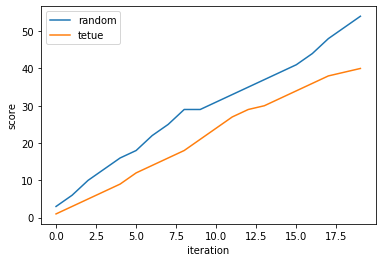

{'random': {'score': 54, 'max': 13, 'produit': 130130}, 'tetue': {'score': 40, 'max': 13, 'produit': 20800}}


In [8]:
kolkata(["random" , "tetue"])

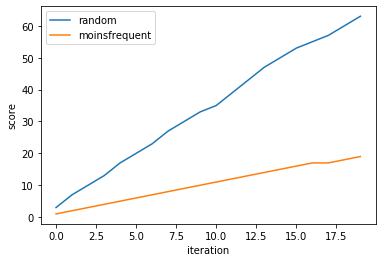

{'random': {'score': 63, 'max': 15, 'produit': 267540}, 'moinsfrequent': {'score': 19, 'max': 7, 'produit': 448}}


In [9]:
kolkata(["random" , "moinsfrequent"])

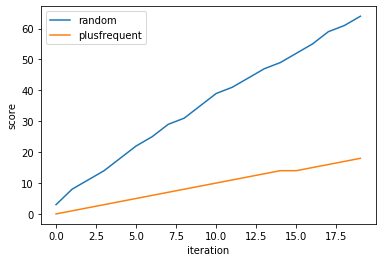

{'random': {'score': 64, 'max': 15, 'produit': 305760}, 'plusfrequent': {'score': 18, 'max': 5, 'produit': 480}}


In [10]:
kolkata(["random" , "plusfrequent"])

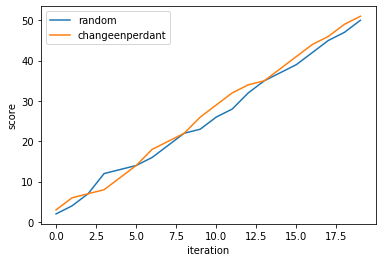

{'random': {'score': 50, 'max': 13, 'produit': 78624}, 'changeenperdant': {'score': 51, 'max': 15, 'produit': 92160}}


In [11]:
kolkata(["random" , "changeenperdant"])

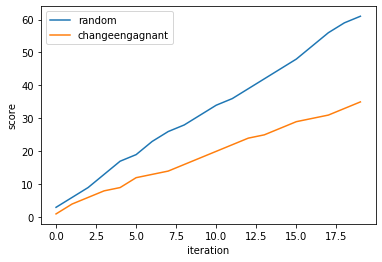

{'random': {'score': 61, 'max': 15, 'produit': 249480}, 'changeengagnant': {'score': 35, 'max': 9, 'produit': 11907}}


In [12]:
kolkata(["random" , "changeengagnant"])

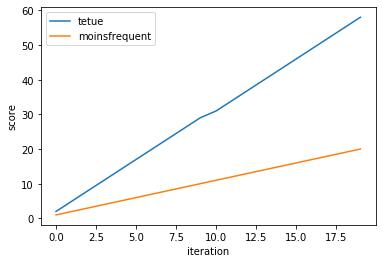

{'tetue': {'score': 58, 'max': 18, 'produit': 171072}, 'moinsfrequent': {'score': 20, 'max': 7, 'produit': 672}}


In [13]:
kolkata(["tetue" , "moinsfrequent"])

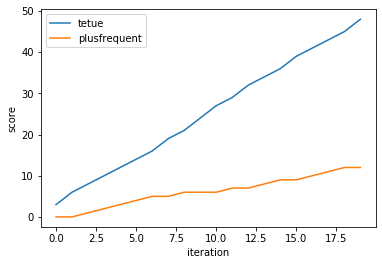

{'tetue': {'score': 48, 'max': 20, 'produit': 0}, 'plusfrequent': {'score': 12, 'max': 4, 'produit': 48}}


In [14]:
kolkata(["tetue" , "plusfrequent"])

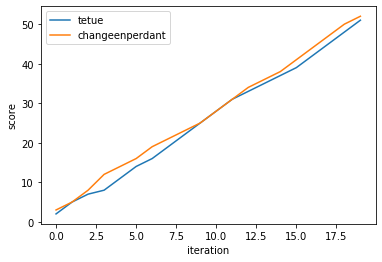

{'tetue': {'score': 51, 'max': 18, 'produit': 71280}, 'changeenperdant': {'score': 52, 'max': 14, 'produit': 98098}}


In [15]:
kolkata(["tetue" , "changeenperdant"])

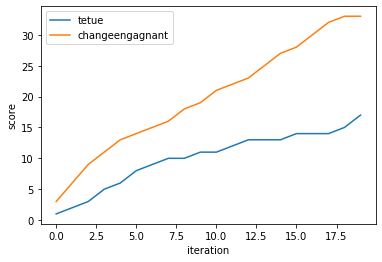

{'tetue': {'score': 17, 'max': 10, 'produit': 0}, 'changeengagnant': {'score': 33, 'max': 8, 'produit': 11520}}


In [16]:
kolkata(["tetue" , "changeengagnant"])

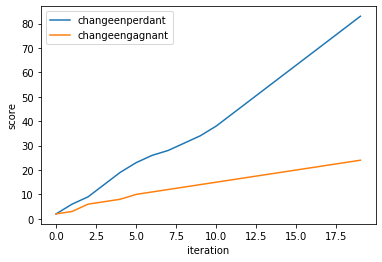

{'changeenperdant': {'score': 83, 'max': 20, 'produit': 1198080}, 'changeengagnant': {'score': 24, 'max': 6, 'produit': 2160}}


In [17]:
kolkata(["changeenperdant" , "changeengagnant"])